In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import seaborn as sns

In [2]:
#df = pd.read_csv("data/testdata_000000000001.csv", index_col="clusterid")
print("\n Loading data")
df = pd.read_csv("new_data/preprocessing_data_scaler.csv",index_col="clusterid",dtype=np.float32)
df.index = df.index.map(int)
print("\n End loading data")



 Loading data

 End loading data


In [3]:
df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Float64Index: 437585954 entries, 243922944.0 to 911556736.0
Data columns (total 8 columns):
 #   Column  Non-Null Count      Dtype  
---  ------  --------------      -----  
 0   OTD     437585954 non-null  float32
 1   IND     437585954 non-null  float32
 2   ACT     437585954 non-null  float32
 3   DACT    437585954 non-null  float32
 4   TAR     437585954 non-null  float32
 5   AAR     437585954 non-null  float32
 6   TAS     437585954 non-null  float32
 7   AAS     437585954 non-null  float32
dtypes: float32(8)
memory usage: 16.3 GB


In [4]:
from sklearn.cluster import MiniBatchKMeans

kmeans = MiniBatchKMeans(n_clusters=100, random_state=42,verbose=100).fit(df)


Init 1/3 with method k-means++
Inertia for init 1/3: 5855486.0
Init 2/3 with method k-means++
Inertia for init 2/3: 18579434.0
Init 3/3 with method k-means++
Inertia for init 3/3: 9603307.0
[MiniBatchKMeans] Reassigning 91 cluster centers.
Minibatch step 1/42733003: mean batch inertia: 16908.533203125
Minibatch step 2/42733003: mean batch inertia: 7519.6767578125, ewa inertia: 7519.6767578125
Minibatch step 3/42733003: mean batch inertia: 15279.7900390625, ewa inertia: 7519.7130768758025
Minibatch step 4/42733003: mean batch inertia: 783552.9375, ewa inertia: 7523.345085685634
Minibatch step 5/42733003: mean batch inertia: 182372.0, ewa inertia: 7524.163416441394
Minibatch step 6/42733003: mean batch inertia: 3988.2978515625, ewa inertia: 7524.146867800849
Minibatch step 7/42733003: mean batch inertia: 1389351.0, ewa inertia: 7530.614126091199
Minibatch step 8/42733003: mean batch inertia: 1361708.75, ewa inertia: 7536.951982209707
Minibatch step 9/42733003: mean batch inertia: 11791.5

In [8]:
df["labels"] = labels = kmeans.labels_

In [ ]:
# from sklearn import metrics

# print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(df, kmeans.labels_))

# print("\n Ending Metrics")

In [ ]:
# from yellowbrick.cluster import KElbowVisualizer
# # Instantiate the clustering model and visualizer
# model = MiniBatchKMeans(n_clusters=10000, random_state=42,verbose=100)

# visualizer = KElbowVisualizer(model, k=list(10**i for i in range(0,6)))

# visualizer.fit(df)        # Fit the data to the visualizer
# visualizer.show()        # Finalize and render the figure

In [ ]:
# # Compute OPTICS
# print("\n Starting OPTICS")
# from sklearn import metrics
# from sklearn.cluster import OPTICS
# db = OPTICS(n_jobs=-1,min_samples=100,max_eps=0.1).fit(sample)
# print("\n Ending OPTICS")


In [ ]:
# # Compute DBSCAN
# print("\n Starting DBSCAN")
# from sklearn import metrics
# from sklearn.cluster import DBSCAN
# db = DBSCAN(eps=0.0001, min_samples=100,n_jobs=1).fit(sample)
# print("\n Ending DBSCAN")



 Starting DBSCAN


In [ ]:
# # metrics
# print("\nStarting Metrics")

# core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
# core_samples_mask[db.core_sample_indices_] = True

# df["labels"] = labels = db.labels_

# # Number of clusters in labels, ignoring noise if present.
# n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
# n_noise_ = list(labels).count(-1)

# print("Estimated number of clusters: %d" % n_clusters_)
# print("Estimated number of noise points: %d" % n_noise_)
# #print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
# #print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
# #print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
# #print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(labels_true, labels))
# #print(
# #    "Adjusted Mutual Information: %0.3f"
# #    % metrics.adjusted_mutual_info_score(labels_true, labels)
# #)
# #print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(sample, labels))

# print("\n Ending Metrics")


In [9]:
# sample.labels.value_counts()

-1       42680312
 4          32535
 52         24319
 20         23225
 18         20202
           ...   
 1107         100
 279          100
 2449         100
 2051         100
 2372         100
Name: labels, Length: 2642, dtype: int64


 Ploting Results


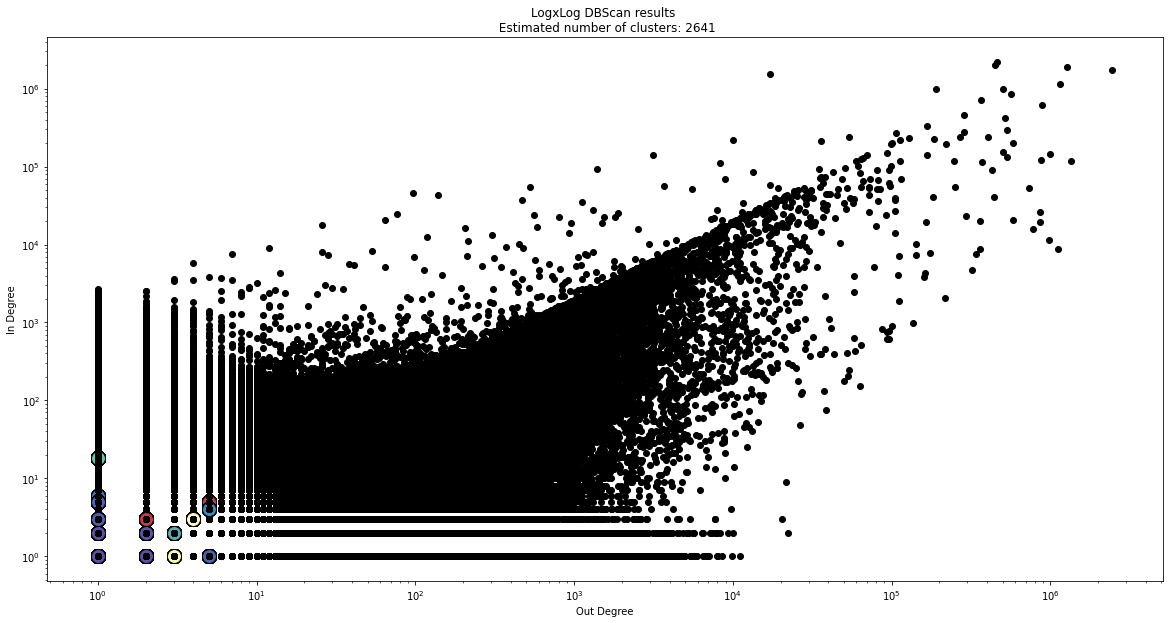


 Ending Results


In [12]:
# # #############################################################################
# # Plot result
# print("\n Ploting Results")

# import matplotlib.pyplot as plt

# # Black removed and is used for noise instead.
# unique_labels = set(labels)
# colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

# fig = plt.figure(figsize=(20,10))
# ax = plt.gca()

# for k, col in zip(unique_labels, colors):
#     if k == -1:
#         # Black used for noise.
#         col = [0, 0, 0, 1]

#     class_member_mask = labels == k

#     xy = sample[class_member_mask & core_samples_mask]
#     plt.plot(xy.OTD,xy.IND,"o",markerfacecolor=tuple(col),markeredgecolor="k",markersize=14)

#     xy = sample[class_member_mask & ~core_samples_mask]
#     plt.plot(xy.OTD, xy.IND,"o",markerfacecolor=tuple(col),markeredgecolor="k",markersize=6)

# ax.set_yscale('log')
# ax.set_xscale('log')

# plt.title("LogxLog DBScan results \n Estimated number of clusters: %d" % n_clusters_)

# plt.xlabel("Out Degree") # X-axis label
# plt.ylabel("In Degree") # Y-axis label

# plt.savefig("clustering.pdf")
# plt.show()

# print("\n Ending Results")


In [11]:
df.head()

,out_degree,in_degree,active_days,degree_per_active_day,total_amount_received,avg_amount_received,total_amount_sent,avg_amount_sent,labels
clusterid,,,,,,,,,
29481527,2,2,1,2.0,1105414,5.527070e+05,2173528,1086764.0,-1
95567879,1,3,1,3.0,1145872445,1.145872e+09,1145822445,381940815.0,-1
168364763,1,2,1,2.0,4867395,4.867395e+06,4830421,2415210.5,-1
117064969,5,2,1,2.0,11158117,2.231623e+06,23741990,11870995.0,-1
7382814,2,2,1,2.0,108033209,5.401660e+07,118366418,59183209.0,-1


In [12]:
print("\n Saving Results")

df.labels.to_csv("clustering_results.csv")

print("\n Results save")



 Saving Results

 Results save
